In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

import nltk
from gensim.models import Word2Vec
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import WordPunctTokenizer
from copy import deepcopy
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm.auto import tqdm
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import os
from pathlib import Path

from collections import Counter
from typing import List
import string

import seaborn as sns
sns.set(palette='summer')

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
!unzip aclImdb.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: aclImdb — копия/train/pos/7269_7.txt  
  inflating: aclImdb — копия/train/pos/5392_10.txt  
  inflating: aclImdb — копия/train/pos/10177_9.txt  
  inflating: aclImdb — копия/train/pos/4684_8.txt  
  inflating: aclImdb — копия/train/pos/11803_7.txt  
  inflating: aclImdb — копия/train/pos/11912_10.txt  
  inflating: aclImdb — копия/train/pos/11040_7.txt  
  inflating: aclImdb — копия/train/pos/8414_7.txt  
  inflating: aclImdb — копия/train/pos/10132_9.txt  
  inflating: aclImdb — копия/train/pos/2806_10.txt  
  inflating: aclImdb — копия/train/pos/10971_9.txt  
  inflating: aclImdb — копия/train/pos/802_10.txt  
  inflating: aclImdb — копия/train/pos/12373_7.txt  
  inflating: aclImdb — копия/train/pos/860_8.txt  
  inflating: aclImdb — копия/train/pos/10005_7.txt  
  inflating: aclImdb — копия/train/pos/9080_7.txt  
  inflating: aclImdb — копия/train/pos/8523_9.txt  
  inflating: aclImdb — копия/train/pos

In [ ]:
data_dir = Path('/content/aclImdb — копия/')

In [ ]:
def read_imdb(data_dir, is_train):
    """Read the IMDb review dataset text sequences and labels."""
    data, labels = [], []
    for label in ('pos', 'neg'):
        folder_name = os.path.join(data_dir, 'train' if is_train else 'test', label)
        for file in os.listdir(folder_name):
            with open(os.path.join(folder_name, file), 'rb') as f:
                name = os.path.basename(file)
                new_label = name[-6:-4]
                review = f.read().decode('utf-8').replace('\n', '')
                data.append(review)
                if new_label.isnumeric():
                    labels.append(int(new_label))
                else:
                    labels.append(int(new_label[-1]))
    return data, labels

train_data = read_imdb(data_dir, is_train=True)
print('trainings:', len(train_data[0]))
for x, y in zip(train_data[0][:3], train_data[1][:3]):
    print('label:', f'{y},', 'text:', x[:])

trainings: 25000
label: 10, text: HLOTS was an outstanding series, its what NYPD Blue will never be, on HLOTS the plots are real, the dialog is real, the Relationships are real. With HLOTS back as a movie, Tying up all the loose ends, it was good to have all the gang back together, even a few that passed away show up (wont say how) The storyline was fast paced, emotional and full of the spirit the series had week in and week out. Homicide , Life on the Streets, Network drama at Its BEST!!!! 5 STARS!!!! Thumbs UP and all That. Thanks NBC for giving us the Finally we didn't get!
label: 10, text: This, like Murder She Wrote, is one of those shows, that after a stressful day at school, I sit down in front of the TV, and watch. Why? Because I genuinely enjoy it, and it's a shame it's not on the air anymore. Dick Van Dyke is amazing as Dr Mark Sloan, a doctor-turned-detective, who with his son, solves murders. He is joined by a largely unknown but very competent supporting cast, namely his r

In [ ]:
test_data = read_imdb(data_dir, is_train=False)
print('len:', len(test_data[0]))
for x, y in zip(test_data[0][:3], test_data[1][:3]):
    print('label:', f'{y},', 'text:', x[:])

len: 25000
label: 9, text: The Story line for this game is very jerky where it appears the game writers have tried to find ways to justify how a character appears in certain areas of the world map in Tales of the Soul. That being said, this is the only gripe I have about the game.<br /><br />The beginning FMV is spectacular with breath taking sceneries and interesting new devices such as the ability to create and design your own character and their own Martial Arts discipline. There's even a second story mode which makes up for the awkward Story design of Tale of the Souls.<br /><br />Parts of the FMVs during Tale of the Souls is also interactive where you can decide the fate of your Character to a certain degree which is an interesting feature.<br /><br />With the many combinations of Characters you can create, the varied paths you can explore in Tales of the Souls and the Chronicle of Swords story mode, this game will keep any Beatem up/RPG fans amused for a while!
label: 8, text: Th

In [ ]:
# d1 = {'text' : train_data[0], 'label' : train_data[1]}
# new_train = pd.DataFrame(data=d1)

In [ ]:
# d2 = {'text' : test_data[0], 'label' : test_data[1]}
# new_test = pd.DataFrame(data=d2)

In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 34.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 61.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 81.1 MB/s eta 0:00:00


In [ ]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [ ]:
print('original: ', train_data[0][0])
print('tokenized: ', tokenizer.tokenize(train_data[0][0]))
print('token ids: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(train_data[0][0])))

original:  HLOTS was an outstanding series, its what NYPD Blue will never be, on HLOTS the plots are real, the dialog is real, the Relationships are real. With HLOTS back as a movie, Tying up all the loose ends, it was good to have all the gang back together, even a few that passed away show up (wont say how) The storyline was fast paced, emotional and full of the spirit the series had week in and week out. Homicide , Life on the Streets, Network drama at Its BEST!!!! 5 STARS!!!! Thumbs UP and all That. Thanks NBC for giving us the Finally we didn't get!
tokenized:  ['h', '##lot', '##s', 'was', 'an', 'outstanding', 'series', ',', 'its', 'what', 'ny', '##pd', 'blue', 'will', 'never', 'be', ',', 'on', 'h', '##lot', '##s', 'the', 'plots', 'are', 'real', ',', 'the', 'dial', '##og', 'is', 'real', ',', 'the', 'relationships', 'are', 'real', '.', 'with', 'h', '##lot', '##s', 'back', 'as', 'a', 'movie', ',', 'tying', 'up', 'all', 'the', 'loose', 'ends', ',', 'it', 'was', 'good', 'to', 'have', 

In [ ]:
# lens = []
# for sent in train_data[0]:
#     input_ids = tokenizer.encode(sent, add_special_tokens=True)
#     lens.append(len(input_ids))

In [ ]:
# print('mean:', np.mean(lens))
# print('max:', max(lens))
# print('min:', min(lens))

In [ ]:
# plt.figure(figsize=(10, 7))
# plt.hist(lens)
# plt.show()

In [ ]:
for i in range(len(train_data[1])):
    if (train_data[1][i] == 1) or (train_data[1][i] == 2):
        train_data[1][i] = 0
    elif (train_data[1][i] == 3) or (train_data[1][i] == 4):
        train_data[1][i] = 1
    elif (train_data[1][i] == 7) or (train_data[1][i] == 8):
        train_data[1][i] = 2
    else:
        train_data[1][i] = 3

In [ ]:
for i in range(len(test_data[1])):
    if (test_data[1][i] == 1) or (test_data[1][i] == 2):
        test_data[1][i] = 0
    elif (test_data[1][i] == 3) or (test_data[1][i] == 4):
        test_data[1][i] = 1
    elif (test_data[1][i] == 7) or (test_data[1][i] == 8):
        test_data[1][i] = 2
    else:
        test_data[1][i] = 3

In [ ]:
input_ids = []
attention_masks = []
for text in train_data[0]:
    encoded_dict = tokenizer.encode_plus(
                        text,
                        add_special_tokens = True,
                        max_length = 512,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                   )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(train_data[1])

print('Original: ', train_data[0][0])
print('Token IDs:', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  HLOTS was an outstanding series, its what NYPD Blue will never be, on HLOTS the plots are real, the dialog is real, the Relationships are real. With HLOTS back as a movie, Tying up all the loose ends, it was good to have all the gang back together, even a few that passed away show up (wont say how) The storyline was fast paced, emotional and full of the spirit the series had week in and week out. Homicide , Life on the Streets, Network drama at Its BEST!!!! 5 STARS!!!! Thumbs UP and all That. Thanks NBC for giving us the Finally we didn't get!
Token IDs: tensor([  101,  1044, 10994,  2015,  2001,  2019,  5151,  2186,  1010,  2049,
         2054,  6396, 17299,  2630,  2097,  2196,  2022,  1010,  2006,  1044,
        10994,  2015,  1996, 14811,  2024,  2613,  1010,  1996, 13764,  8649,
         2003,  2613,  1010,  1996,  6550,  2024,  2613,  1012,  2007,  1044,
        10994,  2015,  2067,  2004,  1037,  3185,  1010, 15233,  2039,  2035,
         1996,  6065,  4515,  1010,  2

In [ ]:
dataset = TensorDataset(input_ids, attention_masks, labels)
# stratify - label
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

22,500 training samples
2,500 validation samples


In [ ]:
batch_size = 16
train_dataloader = DataLoader(train_dataset, sampler = RandomSampler(train_dataset), batch_size = batch_size)
validation_dataloader = DataLoader(val_dataset, sampler = SequentialSampler(val_dataset), batch_size = batch_size )

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = 4,
    output_attentions = False,
    output_hidden_states = False,
)
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [ ]:
from transformers import get_linear_schedule_with_warmup
optimizer = AdamW(model.parameters(), lr = 2e-5, eps = 1e-8)
epochs = 4
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import random
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []

for epoch in range(epochs):
    total_train_loss = 0
    model.train()
    for step, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}')):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        model.zero_grad()
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        logits = outputs.logits
        total_train_loss += loss.item()
        loss.backward()
        # Clip the norm of the gradients to 1.0. - this is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)
    print("Average training loss: {0:.2f}".format(avg_train_loss))

    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    model.eval()
    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
            loss = outputs.loss
            logits = outputs.logits

        total_eval_loss += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        total_eval_accuracy += flat_accuracy(logits, label_ids)

    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("Average validation accuracy: {0:.2f}".format(avg_val_accuracy))

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    print("Average validation Loss: {0:.2f}".format(avg_val_loss))

    training_stats.append(
        {
            'epoch': epoch + 1,
            'Training loss': avg_train_loss,
            'Validation loss': avg_val_loss,
            'Validation accuracy': avg_val_accuracy,
        }
    )

Training epoch 0:   0%|          | 0/1407 [00:00<?, ?it/s]

Average training loss: 0.79
Average validation accuracy: 0.69
Average validation Loss: 0.70


Training epoch 1:   0%|          | 0/1407 [00:00<?, ?it/s]

Average training loss: 0.57
Average validation accuracy: 0.71
Average validation Loss: 0.70


Training epoch 2:   0%|          | 0/1407 [00:00<?, ?it/s]

Average training loss: 0.41
Average validation accuracy: 0.71
Average validation Loss: 0.79


Training epoch 3:   0%|          | 0/1407 [00:00<?, ?it/s]

Average training loss: 0.29
Average validation accuracy: 0.71
Average validation Loss: 0.89


In [ ]:
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats

,Training loss,Validation loss,Validation accuracy
epoch,,,
1,0.790523,0.702348,0.688694
2,0.565019,0.700839,0.709793
3,0.405181,0.785606,0.708599
4,0.288774,0.894362,0.708201


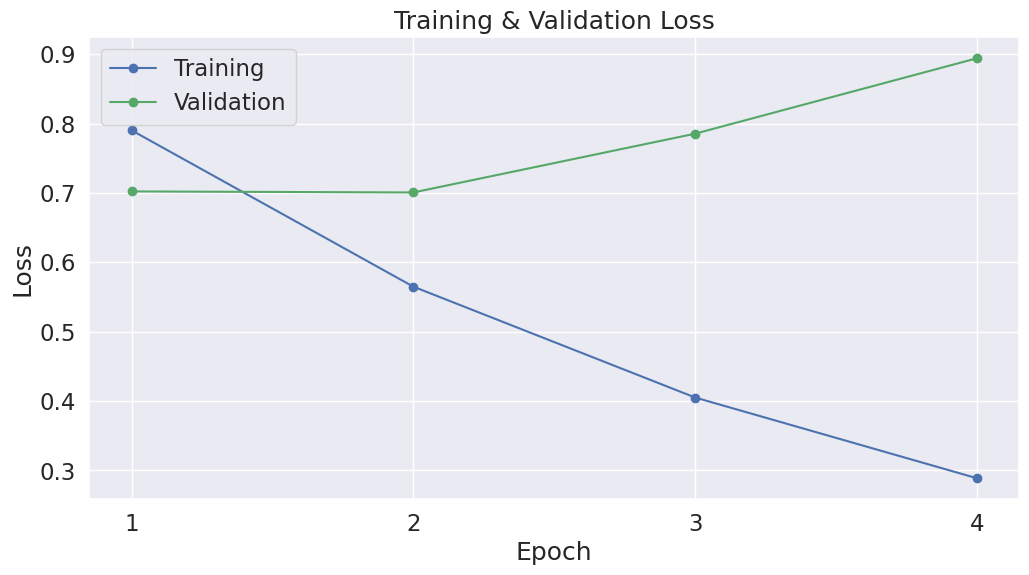

In [ ]:
sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(df_stats['Training loss'], 'b-o', label="Training")
plt.plot(df_stats['Validation loss'], 'g-o', label="Validation")

plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [ ]:
test_input_ids = []
test_attention_masks = []
for text in test_data[0]:
    encoded_dict = tokenizer.encode_plus(
                        text,
                        add_special_tokens = True,
                        max_length = 512,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                   )
    test_input_ids.append(encoded_dict['input_ids'])
    test_attention_masks.append(encoded_dict['attention_mask'])
test_input_ids = torch.cat(test_input_ids, dim=0)
test_attention_masks = torch.cat(test_attention_masks, dim=0)
test_labels = torch.tensor(test_data[1])

print('Original: ', test_data[0][0])
print('Token IDs:', test_input_ids[0])

Original:  The Story line for this game is very jerky where it appears the game writers have tried to find ways to justify how a character appears in certain areas of the world map in Tales of the Soul. That being said, this is the only gripe I have about the game.<br /><br />The beginning FMV is spectacular with breath taking sceneries and interesting new devices such as the ability to create and design your own character and their own Martial Arts discipline. There's even a second story mode which makes up for the awkward Story design of Tale of the Souls.<br /><br />Parts of the FMVs during Tale of the Souls is also interactive where you can decide the fate of your Character to a certain degree which is an interesting feature.<br /><br />With the many combinations of Characters you can create, the varied paths you can explore in Tales of the Souls and the Chronicle of Swords story mode, this game will keep any Beatem up/RPG fans amused for a while!
Token IDs: tensor([  101,  1996,  

In [ ]:
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)
test_dataloader = DataLoader(test_dataset, sampler = SequentialSampler(test_dataset), batch_size = batch_size)

In [ ]:
def predict(model, test_loader):
    model.eval()
    total_test_accuracy = 0
    for batch in test_loader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
            logits = outputs.logits

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        total_test_accuracy += flat_accuracy(logits, label_ids)
    accuracy = total_test_accuracy / len(test_loader)
    return accuracy

In [31]:
accuracy = predict(model, test_dataloader)

In [32]:
print("Average test accuracy: {0:.2f}".format(accuracy))

Average tast accuracy: 0.72
